In [7]:
from collections import defaultdict
from copy import deepcopy
import re
from typing import Callable, List, Tuple

from datasets import load_dataset
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
from torch import nn
import torch.nn.functional as F
from tqdm.auto import tqdm
from datetime import datetime
from sklearn.utils import shuffle

In [8]:
dataset = load_dataset("imdb")

Reusing dataset imdb (/home/miolith/.cache/huggingface/datasets/imdb/plain_text/1.0.0/2fdd8b9bcadd6e7055e742a706876ba43f19faee861df134affd7a3f60fc38a1)


  0%|          | 0/3 [00:00<?, ?it/s]

In [9]:
# We do not need the "unsupervised" split.
dataset.pop("unsupervised")

Dataset({
    features: ['text', 'label'],
    num_rows: 50000
})

In [10]:
dataset

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 25000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 25000
    })
})

In [7]:
dataset["train"][:2]

{'text': ['I rented I AM CURIOUS-YELLOW from my video store because of all the controversy that surrounded it when it was first released in 1967. I also heard that at first it was seized by U.S. customs if it ever tried to enter this country, therefore being a fan of films considered "controversial" I really had to see this for myself.<br /><br />The plot is centered around a young Swedish drama student named Lena who wants to learn everything she can about life. In particular she wants to focus her attentions to making some sort of documentary on what the average Swede thought about certain political issues such as the Vietnam War and race issues in the United States. In between asking politicians and ordinary denizens of Stockholm about their opinions on politics, she has sex with her drama teacher, classmates, and married men.<br /><br />What kills me about I AM CURIOUS-YELLOW is that 40 years ago, this was considered pornographic. Really, the sex and nudity scenes are few and far b

### Pretreatment (1 point)

In [11]:
import string
import re

def pretreatment(text: str) -> str:
    """Clean IMDB text entries.
    Args:
        text: an input string.
    Returns:
        The cleaned text.
    """
    t = text.lower()
    t = re.sub('[{}]'.format(string.punctuation), ' ', t)
    
    return t

In [12]:
# This applies the pretreatment function to all
clean_dataset = dataset.map(lambda x: {"text": pretreatment(x["text"]), "label": x["label"]})

  0%|          | 0/25000 [00:00<?, ?ex/s]

  0%|          | 0/25000 [00:00<?, ?ex/s]

In [13]:
clean_dataset["train"]["text"][:3]

['i rented i am curious yellow from my video store because of all the controversy that surrounded it when it was first released in 1967  i also heard that at first it was seized by u s  customs if it ever tried to enter this country  therefore being a fan of films considered  controversial  i really had to see this for myself  br    br   the plot is centered around a young swedish drama student named lena who wants to learn everything she can about life  in particular she wants to focus her attentions to making some sort of documentary on what the average swede thought about certain political issues such as the vietnam war and race issues in the united states  in between asking politicians and ordinary denizens of stockholm about their opinions on politics  she has sex with her drama teacher  classmates  and married men  br    br   what kills me about i am curious yellow is that 40 years ago  this was considered pornographic  really  the sex and nudity scenes are few and far between  e

In [14]:
clean_dataset["train"]["label"][12490:12510]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]

### Train/validation split (1 point)

In [15]:
clean_dataset_split = clean_dataset["train"].train_test_split(train_size=0.8, seed=42)

clean_dataset_split["validation"] = clean_dataset_split.pop("test")
clean_dataset_split["test"] = clean_dataset["test"]

In [16]:
clean_dataset_split

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 20000
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 5000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 25000
    })
})

In [17]:
print("Le dataset est environ équilibré :", sum(clean_dataset_split["train"]["label"]), "/ 20 000")
print("Le dataset est environ équilibré :", sum(clean_dataset_split["validation"]["label"]), "/ 5000")

print("Les proportions sont environ équilibrés")

Le dataset est environ équilibré : 9994 / 20 000
Le dataset est environ équilibré : 2506 / 5000
Les proportions sont environ équilibrés


### Categorical encoding of the vocabulary (2 points)

In [19]:
UNK_TOKEN = "<UNK>"
PAD_TOKEN = "<PAD>"


class Vocabulary:
    """Vocabulary manager on a collection.
    """
    def __init__(self) -> None:
        """No parameters to provide.
        """
        # Index to word mapping.
        self.index2word = [PAD_TOKEN, UNK_TOKEN]
        # Word to index mapping.
        self.word2index = {value: key for key, value in enumerate(self.index2word)}
        # Word counter.
        self.word2count = defaultdict(int)

    def add_word(self, word: str) -> None:
        """Increments the count of a word to the vocabulary.
        Args:
            word: the word.
        """
        self.word2count[word] += 1
        if not word in self.word2index:
            self.word2index[word] = len(self.index2word)
            self.index2word.append(word)

    def add_text(self, text: str, separator: str =" ") -> None:
        """Add the words given in a text to our vocabulary.
        Args:
            text: a sequence of words separated by a given separator.
            separator: the separator used to split our text (default is " ").
        """
        for word in text.split(separator):
            self.add_word(word)

    def get_index(self, word: str) -> int:
        """Returns the index of a given word in our vocabulary.
        If the word is not in the vocabulary, returns the index for UNK_TOKEN.
        Args:
            word: a string.
        Returns:
            The corresponding index or the index for UNK_TOKEN.
        """
        return (
            self.word2index[word]
            if word in self.word2index
            else self.word2index[UNK_TOKEN]
        )

    def get_word(self, index: int) -> str:
        """Returns the word at a given index in our vocabulary.
        Args:
            index: the word position in our vocabulary.
        Returns:
            The word corresponding to the given index.
        """
        return self.index2word[index]

    def get_word_count(self, word: str) -> int:
        """Returns the number of occurences for a given word.
        Raise a 
        Args:
            The word.
        Returns:
            Its number of measured occurences.
        """
        return self.word2count[word]

    def get_vocabulary(self) -> List[str]:
        """Returns a copy of the whole vocabulary list.
        Returns:
            A list of words.
        """
        return deepcopy(self.index2word)

    def __len__(self) -> int:
        """len() function.
        Returns:
            The number of words in the vocabulary.
        """
        return len(self.index2word)

    def trim_vocabulary(self, min_occurences: int = 5) -> None:
        """Trim the vocabulary based on the number of occurrences of each words.
        Note that whole counts of deleted words are added to the UNK_TOKEN counts.
        Args:
            min_occurences: the minimum number of occurences for a word to be kept.
        """
        to_delete = {
            word for word, count in self.word2count.items() if count < min_occurences
        }
        new_word2count = defaultdict(int)
        for word, count in self.word2count.items():
            if word not in to_delete:
                new_word2count[word] = count
            else:
                new_word2count[UNK_TOKEN] += count
        new_index2word = [word for word in self.index2word if word not in to_delete]
        new_word2index = {word: index for index, word in enumerate(new_index2word)}

        self.word2count = new_word2count
        self.index2word = new_index2word
        self.word2index = new_word2index

(1 point) Get the vocabulary on both the training and validation set using the Vocabulary class. Remember, we don't use the test set here as we consider it as proxy production data. The trim it down as you see fit (around 20K words in the vocabulary is a good value).

In [21]:
vocabulary = Vocabulary()

# Your code...

for text in clean_dataset["train"]["text"]:
    vocabulary.add_text(text)

c = 5
while len(vocabulary.word2count) > 20000:
    vocabulary.trim_vocabulary(c)
    c += 1

print("Il y a", len(vocabulary.word2count), "mots de vocabulaire différents")

Il y a 19111 mots de vocabulaire différents


(1 point) Fill the encoding and decoding functions. The encoding function takes a text as input and returns a list IDs corresponding to the index of each word in the vocabulary. The decoding function reverse the process, turning a list of IDs into a text. Make sure the encoding function returns a numpy array.

In [22]:
# Encoding and decoding function

def encode_text(text: str) -> np.ndarray:
    # Your code.
    
    rep = []
    for word in text.split(' '):
        rep.append(vocabulary.word2index.get(word, vocabulary.word2index[UNK_TOKEN]))
        
    return np.array(rep)

def decode_text(encoded_text: np.ndarray) -> str:
    # Your code.
    
    return " ".join(map((lambda x : vocabulary.index2word[x]), encoded_text))

To make sure everything went well, we compare a text before and after encoding and then decoding it. You should see rare words / typos replaced by the <UNK> token.

In [23]:
# Apply the encoding function to the entire dataset.
encoded_dataset = clean_dataset_split.map(lambda x: {"text": encode_text(x["text"]), "label": x["label"]})

  0%|          | 0/20000 [00:00<?, ?ex/s]

  0%|          | 0/5000 [00:00<?, ?ex/s]

  0%|          | 0/25000 [00:00<?, ?ex/s]

In [24]:
encoded_dataset["train"]["text"][0]

[723,
 12272,
 2092,
 175,
 42,
 132,
 2205,
 25,
 202,
 2092,
 276,
 315,
 700,
 123,
 42,
 151,
 1475,
 20,
 530,
 3414,
 79,
 14,
 723,
 25,
 86,
 87,
 25,
 492,
 2246,
 25,
 25,
 25,
 15064,
 15065,
 31,
 1565,
 1751,
 14,
 151,
 5426,
 25,
 225,
 54,
 515,
 2589,
 1057,
 14,
 765,
 2838,
 667,
 169,
 603,
 695,
 25,
 432,
 25,
 18,
 31,
 1457,
 36,
 650,
 28,
 50,
 80,
 18,
 54,
 25,
 14,
 4224,
 94,
 1946,
 8359,
 90,
 6538,
 6539,
 54,
 851,
 4852,
 25,
 14,
 10932,
 12,
 98,
 4826,
 116,
 5323,
 25,
 8359,
 54,
 2422,
 87,
 635,
 25,
 90,
 6539,
 1641,
 182,
 12,
 144,
 117,
 4492,
 36,
 47,
 870,
 25,
 52,
 25,
 25,
 25,
 52,
 25,
 25,
 2,
 1823,
 16,
 2,
 197,
 511,
 198,
 13018,
 15063,
 31,
 559,
 25,
 172,
 2,
 2653,
 16,
 4184,
 1,
 973,
 31,
 2374,
 54,
 9368,
 25,
 14,
 914,
 54,
 3616,
 828,
 25,
 90,
 1751,
 261,
 3538,
 25,
 25,
 19024,
 25,
 54,
 191,
 10680,
 2243,
 151,
 25,
 90,
 54,
 12067,
 50,
 3022,
 13,
 871,
 12,
 723,
 90,
 948,
 25,
 52,
 25,
 25,
 25,
 5

In [25]:
clean_dataset["train"]["text"][0], decode_text(encoded_dataset["train"]["text"][0])

('i rented i am curious yellow from my video store because of all the controversy that surrounded it when it was first released in 1967  i also heard that at first it was seized by u s  customs if it ever tried to enter this country  therefore being a fan of films considered  controversial  i really had to see this for myself  br    br   the plot is centered around a young swedish drama student named lena who wants to learn everything she can about life  in particular she wants to focus her attentions to making some sort of documentary on what the average swede thought about certain political issues such as the vietnam war and race issues in the united states  in between asking politicians and ordinary denizens of stockholm about their opinions on politics  she has sex with her drama teacher  classmates  and married men  br    br   what kills me about i am curious yellow is that 40 years ago  this was considered pornographic  really  the sex and nudity scenes are few and far between  e

### Batch preparation (1 point)

To speed up learning, and take advantage of the GPU architecture, we provide data to the model by batches. Since all line in the same batch need to have the same length, we pad lines to the maximum length of each batch.

In [26]:
def data_generator(X: np.ndarray, y: np.ndarray, batch_size: int = 32, pad_right: bool = False) -> Tuple[np.ndarray, np.ndarray]:
    """Generate randomly ordered batches of data+labels.
    Args:
        X: the input data.
        y: the corresponding labels.
        batch_size: the size of each batch [32].
        pad_right: if true, the padding is done on the right [False].
    """
    
    X, y = shuffle(X, y)
    n_batches = int(np.ceil(len(y) / batch_size))
    
    for i in range(n_batches):
        
        end = min((i+1)*batch_size, len(y))
        
        X_batch = X[i*batch_size:end]
        y_batch = y[i*batch_size:end]

        # Padding to max ength size within the batch
        max_len = np.max([len(x) for x in X_batch])
        for j in range(len(X_batch)):
            x = X_batch[j]
            pad = [vocabulary.get_index(PAD_TOKEN)] * (max_len - len(x))
            X_batch[j] = x+pad if pad_right else pad+x

        X_batch = torch.from_numpy(np.array(X_batch)).long()
        y_batch = torch.from_numpy(np.array(y_batch)).long()

        # Yielding results, so every time the function is called, it starts again from here.
        yield X_batch, y_batch

Let's see what the batches look like.

In [27]:
for inputs, labels in data_generator(encoded_dataset["train"]["text"], encoded_dataset["train"]["label"]):
    print("inputs", inputs, "shape:", inputs.shape)
    print("labels", labels, "shape:", labels.shape)
    break

inputs tensor([[    0,     0,     0,  ...,  1329,   182,    25],
        [    0,     0,     0,  ...,   313, 11717,    25],
        [    0,     0,     0,  ...,  2855,  2002,    25],
        ...,
        [    0,     0,     0,  ..., 17171,    25,    25],
        [    0,     0,     0,  ...,    12,    16,    25],
        [    0,     0,     0,  ...,    25,    25,    25]]) shape: torch.Size([32, 1181])
labels tensor([0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1,
        1, 0, 0, 1, 0, 0, 1, 0]) shape: torch.Size([32])


(1 point) Question: On which side should we pad the data for our use case and why?

## The answer is 42

### The model (13 points)

We use a simple RNN with a configurable number of layers.

In [28]:
# Before starting, let's set up the device. A GPU if available, else the CPU.
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [29]:
class RNN(nn.Module):
    """A simple RNN module with word embeddings.
    """
    def __init__(self, vocab_size: int, embed_size: int, hidden_size: int, n_layers: int, n_outputs: int) -> None:
        """
        Args:
            vocab_size: vocabulary size.
            embed_size: embedding dimensions.
            hidden_size: hidden layer size.
            n_layers: the number of layers.
            n_outputs: the number of output classes.
        """
        super().__init__()
        self.vocab_size = vocab_size
        self.embed_size = embed_size
        self.hidden_size = hidden_size
        self.n_layers = n_layers
        self.n_outputs = n_outputs


        # The word embedding layer.
        self.embed = nn.Embedding(self.vocab_size, self.embed_size)
        # The RNN
        self.rnn = nn.RNN(
            input_size = self.embed_size,
            hidden_size = self.hidden_size,
            num_layers = self.n_layers,
            batch_first = True, # Changes the order of dimension to put the batches first.
        )
        # A fully connected layer to project the RNN's output to only one output used for classification.
        self.fc = nn.Linear(self.hidden_size, self.n_outputs)

    def forward(self, X: torch.Tensor) -> torch.Tensor:
        """Function called when the model is called with data as input.
        Args:
            X: the input tensor of dimensions batch_size, sequence length, vocab size (actually just an int).
        Returns:
            The resulting tensor of dimension batch_size, sequence length, output dimensions.
        """
        h0 = torch.zeros(self.n_layers, X.size(0), self.hidden_size).to(device)

        out = self.embed(X)
        # out contains the output layer of all words in the sequence.
        # First dim is batch, second the word in the sequence, third is the vector itself.
        # The second output value is the last vector of all intermediate layer.
        # Only use it if you want to access the intermediate layer values of a
        # multilayer model.
        out, _ = self.rnn(out, h0)
        # Getting the last value only.
        out = out[:, -1, :]
    
        # Linear projection.
        out = self.fc(out)

        return out

Note that we do not pass the output through a sigmoid function. This is because pyTorch implements some code optimization within the BCEWithLogitsLoss we'll see later.

In [113]:
def train(
    model: nn.Module,
    criterion: Callable,
    optimizier: torch.optim.Optimizer,
    n_epochs: int,
    train_gen: Callable,
    valid_gen: Callable,
):
    """Train a model using a batch gradient descent.
    Args:
        model: a class inheriting from nn.Module.
        criterion: a loss criterion.
        optimizer: an optimizer (e.g. Adam, RMSprop, ...).
        n_epochs: the number of training epochs.
        train_gen: a callable function returing a batch (data, labels).
        valid_gen: a callable function returing a batch (data, labels).
    """
    train_losses = np.zeros(n_epochs)
    valid_losses = np.zeros(n_epochs)
    best_valid_loss = np.infty

    for epoch in range(n_epochs):

        t0 = datetime.now()
        model.train()
        train_loss = []

        # Training loop.
        for inputs, labels in train_gen():
            # labels are of dimension (N,) we turn them into (N, 1).
            labels = labels.view(-1, 1).float()
            # Put them on the GPU.
            inputs, labels = inputs.to(device), labels.to(device)

            # Reset the gradient.
            optimizer.zero_grad()

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizier.step()

            train_loss.append(loss.item())  # .item() detach the value from GPU.

        train_losses[epoch] = np.mean(train_loss)

        model.eval()
        valid_loss = []
        # Evaluation loop.
        for inputs, labels in valid_gen():
            labels = labels.view(-1, 1).float()
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)

            valid_loss.append(loss.item())

        valid_losses[epoch] = np.mean(valid_loss)

        print(f"Epoch: {epoch}, training loss: {train_losses[epoch]}, validation loss: {valid_losses[epoch]}, in {datetime.now() - t0}")
        
        
        # हामी उत्तम मोडेल बचत गर्छौं
        if valid_losses[epoch] < best_valid_loss:
            best_valid_loss = valid_losses[epoch]
            torch.save({
                'epoch': epoch+1,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'loss': criterion,
                }, 'best_model.pth')
            
    checkpoint = torch.load('best_model.pth')
    model.load_state_dict(checkpoint['model_state_dict'])
        
    return train_losses, valid_losses, model

We setup the model, criterion (a binary cross entropy), and the optimizer (Adam).

Note that BCEWithLogitsLoss use a mathematical trick to incorporate the sigmoid function in its computation. This trick makes the learning process go slightly faster and is the reason why we didn't put a sigmoid in the forward function of the model.

In [114]:
model = RNN(len(vocabulary), 32, 64, 1, 1).to(device)
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters())

We get the 3 generators.

In [68]:
train_gen = lambda: data_generator(encoded_dataset["train"]["text"], encoded_dataset["train"]["label"])
valid_gen = lambda: data_generator(encoded_dataset["validation"]["text"], encoded_dataset["validation"]["label"])
test_gen = lambda: data_generator(encoded_dataset["test"]["text"], encoded_dataset["test"]["label"])

And train the model.

In [69]:
train_losses, valid_losses, model = train(model, criterion, optimizer, 20, train_gen, valid_gen)

Epoch: 0, training loss: 0.6770735774040222, validation loss: 0.645826469561097, in 0:00:19.724074
Epoch: 1, training loss: 0.6337451196193695, validation loss: 0.6628298581026162, in 0:00:18.803235
Epoch: 2, training loss: 0.5959069635868073, validation loss: 0.5873274414023016, in 0:00:17.717405
Epoch: 3, training loss: 0.5742939840316772, validation loss: 0.5969797765753072, in 0:00:17.881901
Epoch: 4, training loss: 0.5196412842273712, validation loss: 0.6407285104891297, in 0:00:17.271417
Epoch: 5, training loss: 0.49719695329666136, validation loss: 0.604078503740821, in 0:00:17.546821
Epoch: 6, training loss: 0.5079710757255554, validation loss: 0.6617345874476585, in 0:00:18.096178
Epoch: 7, training loss: 0.5102080523967742, validation loss: 0.5647881452445012, in 0:00:17.939302
Epoch: 8, training loss: 0.4172964188337326, validation loss: 0.5307563376274838, in 0:00:17.888167
Epoch: 9, training loss: 0.41076723184585573, validation loss: 0.5598306033262022, in 0:00:17.870752


In [70]:
model

RNN(
  (embed): Embedding(19112, 32)
  (rnn): RNN(32, 64, batch_first=True)
  (fc): Linear(in_features=64, out_features=1, bias=True)
)

We can look at the training and validation loss.

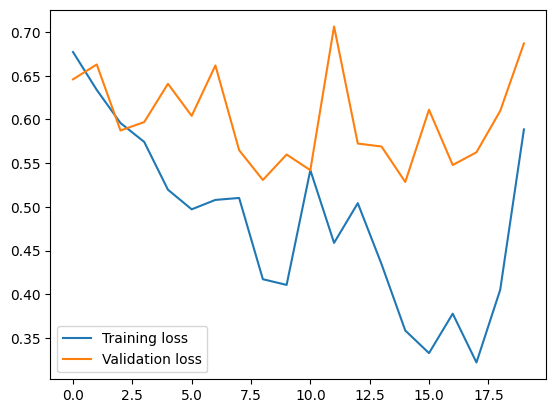

In [71]:
plt.plot(train_losses, label="Training loss")
plt.plot(valid_losses, label="Validation loss")
plt.legend()

For the assignment, code the following.

- (2 points) The model validation loss should go down and then up. It means the model starts overfitting after a certain number of iterations. Modify the train function so it returns the model found with the best validation loss.


- (2 points) Add an accuracy function and report the accuracy of the training and test set.


In [78]:
def check_accuracy(loader, model):
    num_correct = 0
    num_samples = 0
    model.eval()
    
    with torch.no_grad():
        for x, y in loader:
            x = x.to(device=device)
            y = y.to(device=device)
            
            scores = model(x)
            _, predictions = scores.max(1)
            num_correct += (predictions == y).sum()
            num_samples += predictions.size(0)
        
        print(f'Got {num_correct} / {num_samples} with accuracy {float(num_correct)/float(num_samples)*100:.2f}')

In [80]:
check_accuracy(test_gen(), model)

Got 12500 / 25000 with accuracy 50.00


- (3 points) Create an LSTM class which uses an LSTM instead of an RNN. Compare its results with the RNN.


In [99]:
class LSTM(nn.Module):
    """A simple LSTM module with word embeddings.
    """
    def __init__(self, vocab_size: int, embed_size: int, hidden_size: int, n_layers: int, n_outputs: int) -> None:
        """
        Args:
            vocab_size: vocabulary size.
            embed_size: embedding dimensions.
            hidden_size: hidden layer size.
            n_layers: the number of layers.
            n_outputs: the number of output classes.
        """
        super().__init__()
        self.vocab_size = vocab_size
        self.embed_size = embed_size
        self.hidden_size = hidden_size
        self.n_layers = n_layers
        self.n_outputs = n_outputs


        # The word embedding layer.
        self.embed = nn.Embedding(self.vocab_size, self.embed_size)
        # The LSTM
        self.lstm = nn.LSTM(
            input_size = self.embed_size,
            hidden_size = self.hidden_size,
            num_layers = self.n_layers,
            batch_first = True, # Changes the order of dimension to put the batches first.
        )
        # A fully connected layer to project the LSTM's output to only one output used for classification.
        self.fc = nn.Linear(self.hidden_size, self.n_outputs)

    def forward(self, X: torch.Tensor) -> torch.Tensor:
        """Function called when the model is called with data as input.
        Args:
            X: the input tensor of dimensions batch_size, sequence length, vocab size (actually just an int).
        Returns:
            The resulting tensor of dimension batch_size, sequence length, output dimensions.
        """
        h0 = torch.rand(self.n_layers, X.size(0), self.hidden_size).to(device)
        
        c0 = torch.rand(self.n_layers, X.size(0), self.hidden_size).to(device)

        out = self.embed(X)
        # out contains the output layer of all words in the sequence.
        # First dim is batch, second the word in the sequence, third is the vector itself.
        # The second output value is the last vector of all intermediate layer.
        # Only use it if you want to access the intermediate layer values of a
        # multilayer model.
        out, _ = self.lstm(out, (h0, c0))
        # Getting the last value only.
        out = out[:, -1, :]
    
        # Linear projection.
        out = self.fc(out)

        return out

In [100]:
lstm_model = LSTM(len(vocabulary), 32, 64, 1, 1).to(device)
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters())

In [105]:
#train_losses, valid_losses, lstm_model = train(lstm_model, criterion, optimizer, 20, train_gen, valid_gen)

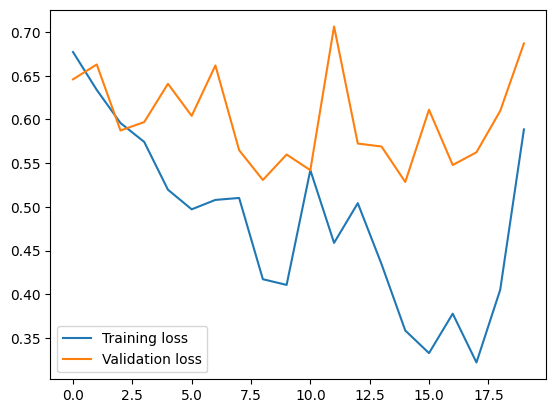

In [98]:
plt.plot(train_losses, label="Training loss")
plt.plot(valid_losses, label="Validation loss")
plt.legend()

- (2 point) Implement a function which takes any text and return the model's prediction.\
The function should have a string as input and return a class (0 or 1) and its probability (score out of a sigmoid).\
Don't forget to make the text go through the same pretreatment and encoding you used to train your model.


In [115]:
def model_predict(model, txt: str) -> int:
    return model(torch.tensor([encode_text(pretreatment(txt))]).to(device))

model_predict(model, "I like this movie a lot")

tensor([[-0.4825]], device='cuda:0', grad_fn=<AddmmBackward0>)

- (3 points) Create a bidirectional LSTM (BiLSTM) class to classify your sentences. Report the accuracy on the training and test data.
To combine the last output of both direction, you can concatenate, add, or max-pool them. Please document your choice.


In [ ]:
class BiLSTM(nn.Module):
    """A simple LSTM module with word embeddings.
    """
    def __init__(self, vocab_size: int, embed_size: int, hidden_size: int, n_layers: int, n_outputs: int) -> None:
        """
        Args:
            vocab_size: vocabulary size.
            embed_size: embedding dimensions.
            hidden_size: hidden layer size.
            n_layers: the number of layers.
            n_outputs: the number of output classes.
        """
        super().__init__()
        self.vocab_size = vocab_size
        self.embed_size = embed_size
        self.hidden_size = hidden_size
        self.n_layers = n_layers
        self.n_outputs = n_outputs

        self.embed = nn.Embedding(self.vocab_size, self.embed_size)
        
        self.lstm = nn.LSTM(
            input_size = self.embed_size,
            hidden_size = self.hidden_size,
            num_layers = self.n_layers,
            batch_first = True
        )
        self.fc = nn.Linear(self.hidden_size, self.n_outputs)

    def forward(self, X: torch.Tensor) -> torch.Tensor:
        """Function called when the model is called with data as input.
        Args:
            X: the input tensor of dimensions batch_size, sequence length, vocab size (actually just an int).
        Returns:
            The resulting tensor of dimension batch_size, sequence length, output dimensions.
        """
        h0 = torch.rand(self.n_layers, X.size(0), self.hidden_size).to(device)
        
        c0 = torch.rand(self.n_layers, X.size(0), self.hidden_size).to(device)

        out = self.embed(X)

        out, _ = self.lstm(out, (h0, c0))

        out = out[:, -1, :]

        out = self.fc(out)

        return out

- (1 point) With your best classifier, look at two wrongly classified examples on the test set. Try explaining why the model was wrong.


- (Bonus) Try finding better hyperparameters (dimensions, number of layers, ...). Document your experiments and results.